In [145]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import uncertainties as uc
from uncertainties import unumpy
from numpy import genfromtxt
from sklearn.metrics import r2_score

In [146]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def lever(x):
    return (50 - x)/(25 - x)

def inv_lever(x):
    return (25 * (-2 + x))/(-1 + x)

def int_lever(x):
    # normalization factor
    # https://www.wolframalpha.com/input?i=int_0%5E%7B21%7D+%2850-x%29%2F%2825-x%29dx
    n = 21 + 25 * np.log(4) + 50 * np.log(25/4) - 25 * np.log(25)
    return 1/n * np.real(x - 25*np.log(x - 25 + 0j) + 25*np.log(25))

def lever_distribution(x):
    arr = []
    for _x in x:
        arr.append(sc.optimize.root(lambda y : np.array(int_lever(y) - _x), _x * 21).x[0])
    return np.array(arr)

#for i in range(100):
#    n=i
#    a = inv_lever(np.linspace(2, 7.25, n))
#    plt.figure()
#    plt.vlines(x=a, ymin=0, ymax=1, color="blue", label="inverse")
#    
#    a = lever_distribution(np.linspace(0,1, n))
#    plt.vlines(x=a, ymin=1, ymax=2, color="red", label="cdf transformation")
#    plt.legend()
#    plt.title(f"{n:05d}")
#    plt.grid()
#    plt.savefig(f"{n:05d}.png", dpi=192)
#    plt.close()

11:10 Uhr Kalibierung der maximalen und minimalen Reichweite des Hebels in Abhängigkeit des Stroms

In [147]:
x = [18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 21.6, 21.75, 22]
y = [14, 15  , 16, 18  , 18, 20  , 23, 25  , 26  , 17   , 18]

plt.grid()
plt.plot(x,y)
plt.scatter(x, y, marker="x", color="black", label="Measured values", zorder = 10)
plt.xticks(np.linspace(18, 22, 5))
plt.ylabel("Current in $\mu A$")
plt.xlabel("Fulcrum in $cm$") 
plt.axvline(21, color="red", label="Chosen cutoff point")
plt.title("Calibration of maximal fulcrum position")
plt.legend()

plt.savefig("fulcrum_calibration.pdf", dpi=196, bbox_inches='tight')

In [148]:
len(x)

11

Unter der Verwendung der Transformation Methode

In [149]:
x = [0,    6.25, 11.45, 15.65, 18.75, 21]
new_x = [0, 8.89, 14.57, 18, 19.9, 21]
y = [25.5, 30  , 37.5 , 49   , 69   , 77  ]

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(new_x,y)

## Quartz bei 20 °C Erste Messung

In [150]:
d11 = 2.3 * 10e-12 # C/N
g = 20

dl = 0.05 # cm
dI = 0.2 # µA

In [151]:
x = np.linspace(2, 7.25, 21)
l = unumpy.uarray(inv_lever(np.linspace(2, 7.25, 21)), dl)

# Amplificttion factor von 20                                                                                
y = [28, 31, 36, 42, 44, 51, 55, 60, 63, 67, 71, 76, 80, 82, 87, 90, 94, 96,
    # amplfication von 10 so we multiple by 2
    48 * 2, 50 * 2, 52*2] # µA
y = unumpy.uarray(y, dI)
y = y/g # g factor
x = lever(l)
len(y)

21

In [152]:
y

array([1.4+/-0.010000000000000002, 1.55+/-0.010000000000000002,
       1.8+/-0.010000000000000002, 2.1+/-0.010000000000000002,
       2.2+/-0.010000000000000002, 2.55+/-0.010000000000000002,
       2.75+/-0.010000000000000002, 3.0+/-0.010000000000000002,
       3.15+/-0.010000000000000002, 3.35+/-0.010000000000000002,
       3.55+/-0.010000000000000002, 3.8+/-0.010000000000000002,
       4.0+/-0.010000000000000002, 4.1+/-0.010000000000000002,
       4.35+/-0.010000000000000002, 4.5+/-0.010000000000000002,
       4.7+/-0.010000000000000002, 4.8+/-0.010000000000000002,
       4.8+/-0.010000000000000002, 5.0+/-0.010000000000000002,
       5.2+/-0.010000000000000002], dtype=object)

In [153]:
plt.figure(figsize=(7, 5))
plt.errorbar(unumpy.nominal_values(x), unumpy.nominal_values(y), label="Measured data", xerr=unumpy.std_devs(x), 
             yerr=unumpy.std_devs(y), ecolor="red", fmt="x", capsize=3, color="black", zorder=100)
plt.xlabel("Leverage factor")
plt.ylabel("Voltage in $\mu V$")
a, b = np.polyfit(unumpy.nominal_values(x), unumpy.nominal_values(y), 1)
plt.plot(unumpy.nominal_values(x), a * unumpy.nominal_values(x) + b, label="Fitted function", color="#1f77b4")
plt.legend()
plt.title("Measurement of gauge constant")
plt.grid()
plt.savefig("quartz_20deg.pdf", bbox_inches='tight')
print(f"x * {a} + {b}")

x * 0.7349412492269635 + 0.06042053184910525


In [154]:
a, b = unumpy.uarray([a,b], np.sqrt(np.diag(np.polyfit(unumpy.nominal_values(x), unumpy.nominal_values(y), 1, cov=True)[1])))
a

0.7349412492269635+/-0.017380282893855306

In [155]:
a/d11

31953967357.694065+/-755664473.645883

In [156]:
gauge_constant = a/(d11) * 10e-6
print(f"{gauge_constant:P}")

(3.20±0.08)×10⁵


In [157]:
r2_score(unumpy.nominal_values(y), a.n * unumpy.nominal_values(x) + b.n)

0.9894859109405535

## Quartz bei $l=0$ mit verschiedenen Temperaturen

In [158]:
def lin_int(x, y):
    x1, x2 = x
    y1, y2 = y
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    return a, b

In [159]:
# zwischen 0 und 11
g = 20
dl = 0.05
dI = 0.2
dT = 1

l1 = uc.ufloat(0, 0.05)
l2 = uc.ufloat(11,0.05)

T = np.array([120, 115, 110, 100, 90, 80, 70, 60, 50, 40, 26])

I = unumpy.uarray([[26, 38], # 120
     [26, 38], # 115
     [26, 38], # 110
     [26, 37], # 100
     [25, 38], # 90
     [26, 37], # 80
     [26, 36], # 70
     [24, 36], # 60
     [25, 37], # 50
     [25, 36], # 40
     [29, 39], # 26
    ], dI) / g

In [160]:
offset = 1e12

In [161]:
a = []
for i in I:
    a.append(lin_int([lever(l1), lever(l2)], i)[0]) # we calculate the a in ax+b
a = np.array(a)
y = a/(gauge_constant) * 10e-6# d11 vals

In [162]:
a, b = np.polyfit(T, unumpy.nominal_values(y) * offset, 1)

In [163]:
print(f"{np.mean(y * offset)}")

22.8+/-0.6


In [164]:
d11 * offset

22.999999999999996

In [186]:
d11

2.2999999999999998e-11

In [165]:
plt.axhline(d11 * offset, color=colors[1], label="Literature $d_{11}$", linestyle="dotted")
plt.axhline(np.mean(unumpy.nominal_values(y) * offset), linestyle="-.", label="Mean of measured values")

plt.errorbar(T, unumpy.nominal_values(y) * offset, yerr = unumpy.std_devs(y) * offset, xerr= np.zeros(len(T)) + dT,capsize=3, 
             label="Measured values", ecolor="red", fmt="x", color="black", zorder=100)
plt.plot(T, a *T + b, color = colors[2], linestyle="dashed", label="Linear fit")
plt.legend()
plt.xlabel("Temperature in °C")
plt.ylabel("Measured $d_{11}$ in pC N$^{-1}$")
plt.title("$d_{11}$ of quartz at different temperatures")
plt.grid()
plt.savefig("d11 quartz.pdf", bbox_inches='tight')

In [166]:
r2_score(unumpy.nominal_values(y) * offset, a*T+b)

0.24707857421230794

cmap = plt.get_cmap('hsv')
for k, i in enumerate(I):
    x = lever(np.array([l1, l2]))
    
    plt.plot(unumpy.nominal_values(x), unumpy.nominal_values(i), label=f"T={T[k]} °C", linestyle="--", color=cmap(k / len(x)))
    plt.errorbar(unumpy.nominal_values(x), unumpy.nominal_values(i), fmt="x"
                 , xerr=unumpy.std_devs(x), yerr=unumpy.std_devs(i), color=cmap(k / len(x)))
plt.legend()

## Austausch auf Barium Titanit

## Veränderung der Dielektrischen Konstante

In [167]:
x = [49.9184339314845, 59.9510603588907, 69.9836867862969, 80.0163132137031, 90.0489396411093, 100.0815660685155, 110.1141924959217]
y = [1155.3398058252426, 1145.631067961165, 1145.631067961165, 1165.0485436893202, 1242.7184466019417, 1417.4757281553398, 2388.349514563107]

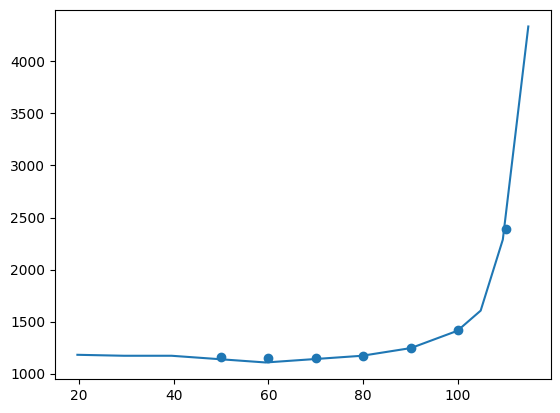

In [168]:
my_data = genfromtxt("dielectric barium/original.csv", delimiter=',')
T = my_data[:,0]
eps = my_data[:,1]
my_data = genfromtxt("dielectric barium/needed.csv", delimiter=',')
_T = my_data[:,0]
_eps = my_data[:,1]

plt.plot(T, eps)

T = unumpy.uarray(x[::-1], 1)
eps = unumpy.uarray(y[::-1], 50)

plt.scatter(unumpy.nominal_values(T), unumpy.nominal_values(eps))


In [169]:
ba_gauge_constant = 4.9 * gauge_constant / eps

plt.plot(unumpy.nominal_values(T), unumpy.nominal_values(ba_gauge_constant), linestyle="dotted")
plt.errorbar(unumpy.nominal_values(T), unumpy.nominal_values(ba_gauge_constant), zorder=100, fmt="x", color="blue", ecolor="red", capsize=3,
            xerr = unumpy.std_devs(T), yerr = unumpy.std_devs(ba_gauge_constant), label="Calculated $\\eta_{\\text{BaTiO}_3}(T)$")
plt.xlabel("Temperature in °C")
plt.ylabel("Gauge constant $\\eta_{\\text{BaTiO}_3}$ in $F^{-1}$")
plt.title("Gauge constant of barium titanate")
plt.legend()
plt.grid()
plt.savefig("gauge_batio3.pdf")

### Polarisiertes Barium Ttanat

In [170]:
dI = 1
dT = 1
dl = 0.05
g = 1

In [171]:
l = inv_lever(np.linspace(2, 7.25, 8))
l = l[:6]
print(l)
l = unumpy.uarray(l, dl)
# 0, 10.7, 15, 17.3, 18.75, 19.7

[ 0.         10.71428571 15.         17.30769231 18.75       19.73684211]


In [172]:
T = [110, 100, 90, 80, 70, 60, 50]
I = [[38, 50, 63, 70, 76, 82], # 110 
     [38, 49, 60, 68, 73, 78], # 100
     [34, 47, 57, 60, 70, 76], # 90
     [32, 44, 54, 63, 68, 73], # 80
     [32, 44, 53, 62, 68, 74], # 70
     [31, 43, 53, 58, 67, 72], # 60
     [31, 43, 53, 61, 68, 72]  # 50
    ]
T = unumpy.uarray(T, dT)
I = unumpy.uarray(I, dI)

In [173]:
for i, k in enumerate(I):
    plt.scatter(unumpy.nominal_values(lever(l)), unumpy.nominal_values(k), marker="x", zorder=100)
    plt.plot(unumpy.nominal_values(lever(l)), unumpy.nominal_values(k), linestyle="dotted", label=f"{T[i].n:n} °C")
plt.xticks(unumpy.nominal_values(lever(l)))
plt.grid()
plt.title("Polarised Barium Titanate")
plt.ylabel("Voltage in $\mu V$")
plt.xlabel("Leverage factor")
plt.legend()
plt.savefig("barium titanate polarized.pdf", bbox_inches='tight')

In [174]:
offset = 1e9
I = I * offset

In [175]:
temp = np.polyfit(unumpy.nominal_values(lever(l)), unumpy.nominal_values(I).T, 1, cov=True, w=np.zeros(len(l)) + dI)
a = unumpy.uarray(temp[0][0], np.sqrt(temp[1][0, 0])) * 1e-6

In [176]:
y = a/ba_gauge_constant

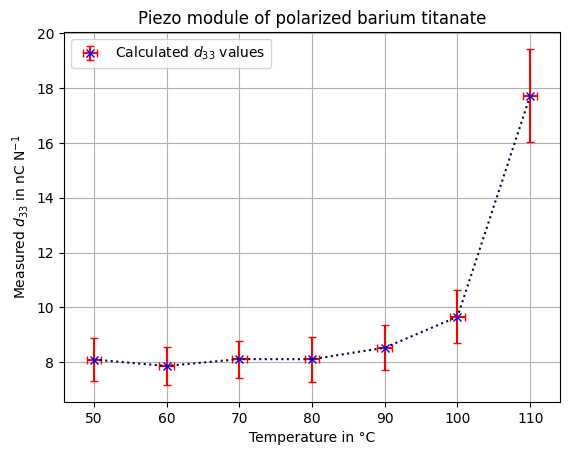

In [177]:
plt.errorbar(unumpy.nominal_values(T), unumpy.nominal_values(y),fmt="x", ecolor="red", color="blue", capsize=3,
            xerr = unumpy.std_devs(T), yerr = unumpy.std_devs(y), label="Calculated $d_{33}$ values")
plt.plot(unumpy.nominal_values(T), unumpy.nominal_values(y), linestyle="dotted", color="#020441")
plt.grid()
plt.xlabel("Temperature in °C")
plt.ylabel("Measured $d_{33}$ in nC N$^{-1}$")
plt.title("Piezo module of polarized barium titanate")
plt.legend()
plt.savefig("pol_bati_d33.pdf", bbox_inches='tight')

### Unpolarisiertes Titanat

In [178]:
dI = 1
dT = 1
dl = 0.05
g = 10

In [179]:
l = inv_lever(np.linspace(2, 7.25, 8))
l = l[:6]
print(l)
l = unumpy.uarray(l, dl)
# 0, 10.7, 15, 17.3, 18.75, 19.7

[ 0.         10.71428571 15.         17.30769231 18.75       19.73684211]


In [180]:
# g = 10
T = [110, 100, 90, 80, 70, 60, 50]
I = [[35/2, 52/2, 64/2, 85/2, 50, 55], # 110 (erste werte mit g = 20)
     [13  , 20  , 28  , 35  , 44, 50], # 100
     [11  , 17  , 25  , 31  , 38, 44], # 90
     [10  , 16  , 22  , 29  , 35, 40], # 80
     [9   , 16  , 22  , 28  , 33, 38], # 70
     [9   , 15  , 20  , 26  , 32, 37], # 60
     [8   , 15  , 20  , 26  , 32, 35], # 50
    ] 
T = unumpy.uarray(T, dT)
I = unumpy.uarray(I, dI) / (g) * 1e-6

In [181]:
for i, k in enumerate(I):
    plt.scatter(unumpy.nominal_values(lever(l)), unumpy.nominal_values(k), marker="x", zorder=100)
    plt.plot(unumpy.nominal_values(lever(l)), unumpy.nominal_values(k), linestyle="dotted", label=f"{T[i].n:n} °C")
plt.xticks(unumpy.nominal_values(lever(l)))
plt.grid()
plt.title("Unpolarised Barium Titanate")
plt.ylabel("Voltage in $\mu V$")
plt.xlabel("Leverage factor")
plt.legend()
plt.savefig("barium titanate unpolarized.pdf", bbox_inches='tight')

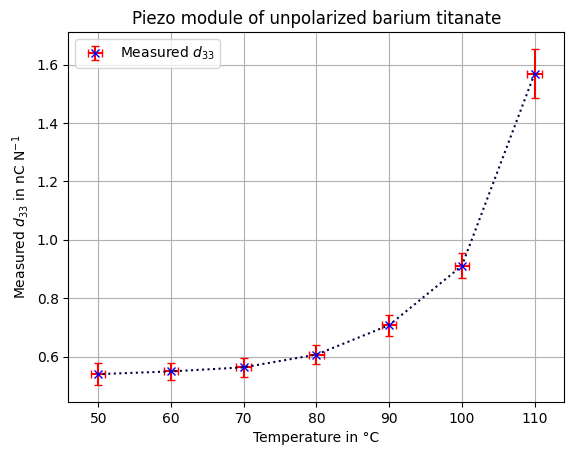

In [182]:
I *= offset
temp = np.polyfit(unumpy.nominal_values(lever(l)), unumpy.nominal_values(I).T, 1, cov=True, w=np.zeros(len(l)) + dI)
a = unumpy.uarray(temp[0][0], np.sqrt(temp[1][0, 0]))

y = a/ba_gauge_constant

plt.errorbar(unumpy.nominal_values(T), unumpy.nominal_values(y), fmt="x", ecolor="red", color="blue", capsize=3,
            xerr = unumpy.std_devs(T),yerr=unumpy.std_devs(y), label="Measured $d_{33}$")
plt.plot(unumpy.nominal_values(T), unumpy.nominal_values(y), linestyle="dotted", color="#020441")
plt.xlabel("Temperature in °C")
plt.ylabel("Measured $d_{33}$ in nC N$^{-1}$")
plt.grid()
plt.legend()
plt.title("Piezo module of unpolarized barium titanate")
plt.savefig("no_pol_bati_d33.pdf", bbox_inches='tight')

In [185]:
print(np.max(y))

1.57+/-0.08


In [184]:
Datenanalyse fertig!!!

SyntaxError: invalid syntax (3137517656.py, line 1)